# Filip Kucia

# P8.1 & P8.2

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_ck_relation_directed(G):
    clustering = nx.clustering(G.to_undirected())  # Convert to undirected for clustering calculation
    
    degree_clustering = defaultdict(list)
    for node in G.nodes():
        k = G.degree(node)  # Total degree (in + out)
        c = clustering[node]
        degree_clustering[k].append(c)
    
    degrees = sorted(degree_clustering.keys())
    avg_clustering = [np.mean(degree_clustering[k]) for k in degrees]
    
    return degrees, avg_clustering

def plot_ck_relation_directed(G, title):
    degrees, clustering = calculate_ck_relation_directed(G)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(degrees, clustering, 'o-', label='C(k)')
    plt.xlabel('Node Degree (k)')
    plt.ylabel('Clustering Coefficient C(k)')
    plt.title(f'C(k) Relation for {title}')
    plt.grid(True)
    plt.legend()
    
    if len(degrees) > 1:
        valid_points = [(np.log10(k), np.log10(c)) 
                       for k, c in zip(degrees, clustering) 
                       if c > 0 and k > 0]
        if valid_points:
            x_fit, y_fit = zip(*valid_points)
            z = np.polyfit(x_fit, y_fit, 1)
            plt.plot(degrees, 10**(z[1]) * np.array(degrees)**z[0], '--',
                    label=f'Fit: γ ≈ {abs(z[0]):.2f}')
            plt.legend()
    
    plt.show()

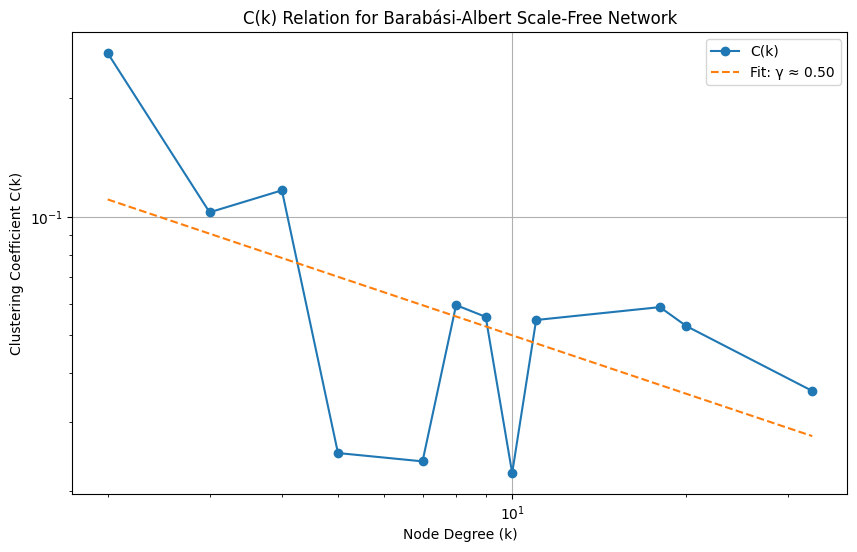

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Generate a Barabási-Albert graph
n_nodes = 100  # Number of nodes
m_links = 2     # Number of edges to attach from a new node to existing nodes
G_ba = nx.barabasi_albert_graph(n=n_nodes, m=m_links)

# Plot the C(k) relation
def plot_ck_relation(G, title):
    clustering = nx.clustering(G)
    
    degree_clustering = defaultdict(list)
    for node in G.nodes():
        k = G.degree(node)
        c = clustering[node]
        degree_clustering[k].append(c)
    
    degrees = sorted(degree_clustering.keys())
    avg_clustering = [np.mean(degree_clustering[k]) for k in degrees]
    
    plt.figure(figsize=(10, 6))
    plt.loglog(degrees, avg_clustering, 'o-', label='C(k)')
    plt.xlabel('Node Degree (k)')
    plt.ylabel('Clustering Coefficient C(k)')
    plt.title(f'C(k) Relation for {title}')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_ck_relation_directed(G_ba, "Barabási-Albert Scale-Free Network")


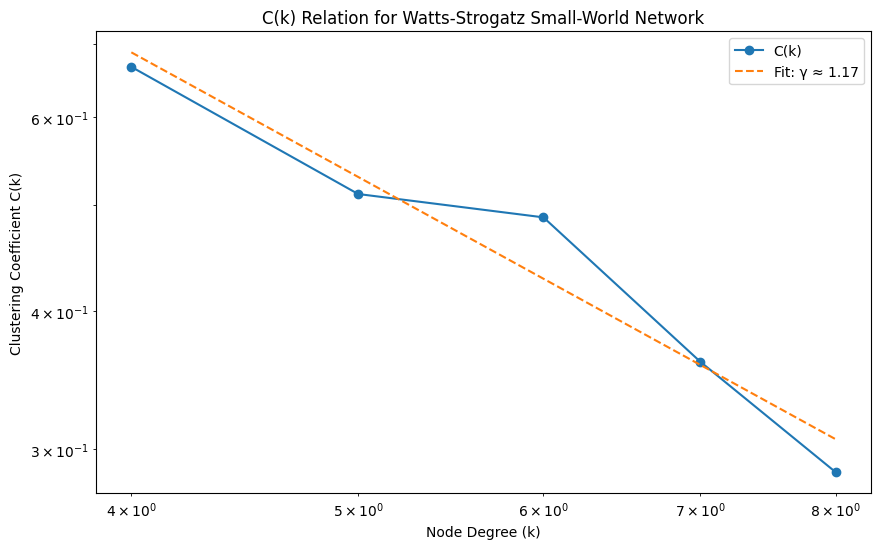

In [7]:
# Generate a Watts-Strogatz graph
n_nodes = 100    # Number of nodes
k_neighbors = 6  # Each node is connected to k nearest neighbors in ring topology
rewiring_prob = 0.1  # Probability of rewiring each edge
G_ws = nx.watts_strogatz_graph(n=n_nodes, k=k_neighbors, p=rewiring_prob)

# Plot the C(k) relation
plot_ck_relation_directed(G_ws, "Watts-Strogatz Small-World Network")

## C. Elegans Neural Network :
A directed graph representing the neural connections of the C. Elegans worm. It reflects hierarchical and modular structures.

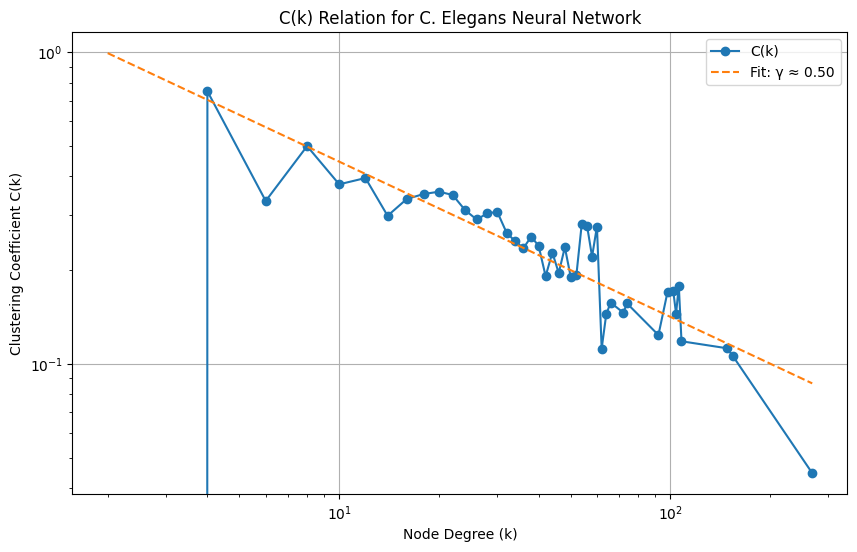

In [60]:
def load_celegans_network(file_path):
    # Create a directed graph
    G = nx.DiGraph()
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip comment lines or empty lines
            if line.startswith('%') or not line.strip():
                continue
            
            # Split the line into parts (source, target, weight)
            parts = line.strip().split()
            if len(parts) >= 3:  # Ensure the line has at least 3 values
                try:
                    u, v, weight = int(parts[0]), int(parts[1]), float(parts[2])
                    G.add_edge(u, v, weight=weight)
                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")
    return G
file_path = "out.dimacs10-celegansneural"  # Replace with your file path
G = load_celegans_network(file_path)

# Analyze and plot the C(k) relation
plot_ck_relation_directed(G, "C. Elegans Neural Network")

# P8.3

In [1]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Optional, Iterator
import logging
from pathlib import Path
from tqdm import tqdm
import sys

class TransitDataLoader:
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.data: Dict[str, Optional[pd.DataFrame]] = {
            'agency': None,
            'calendar': None,
            'routes': None,
            'shapes': None,
            'stops': None,
            'stop_times': None,
            'trips': None
        }
        
        logging.basicConfig(level=logging.INFO, 
                          format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def _count_lines(self, file_path: Path) -> int:
        with open(file_path, 'rb') as f:
            return sum(1 for _ in f)

    def _read_csv_with_progress(self, file_path: Path, chunk_size: int = None) -> Iterator[pd.DataFrame]:
        total_lines = self._count_lines(file_path) - 1  # Subtract header line
        
        if chunk_size is None:
            yield pd.read_csv(file_path)
        else:
            progress_bar = tqdm(
                total=total_lines,
                desc=f"Loading {file_path.stem}",
                unit=' rows',
                position=1,
                leave=False
            )
            
            for chunk in pd.read_csv(file_path, chunksize=chunk_size):
                progress_bar.update(len(chunk))
                yield chunk
            
            progress_bar.close()

    def _load_file(self, filename: str) -> tuple[str, pd.DataFrame]:
        file_path = self.data_dir / f"{filename}.txt"
        self.logger.info(f"Started loading {filename}")
        
        try:
            if filename in ['stop_times', 'shapes', 'trips']:
                chunks = []
                chunk_size = 100000
                
                for chunk in self._read_csv_with_progress(file_path, chunk_size):
                    chunks.append(chunk)
                df = pd.concat(chunks, ignore_index=True)
            else:
                df = pd.read_csv(file_path)
                
            self.logger.info(f"Finished loading {filename}: {len(df)} rows")
            return filename, df
            
        except Exception as e:
            self.logger.error(f"Error loading {filename}: {str(e)}")
            raise

    def load_all_data(self, max_workers: int = 4) -> None:
        self.logger.info(f"Starting data load with {max_workers} workers")
        
        with tqdm(total=len(self.data), desc="Overall progress", position=0) as pbar:
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                future_to_filename = {
                    executor.submit(self._load_file, filename): filename 
                    for filename in self.data.keys()
                }
                
                for future in as_completed(future_to_filename):
                    try:
                        filename, df = future.result()
                        self.data[filename] = df
                        pbar.update(1)
                        pbar.set_postfix_str(f"Completed: {filename}")
                    except Exception as e:
                        self.logger.error(f"Failed to load {future_to_filename[future]}: {str(e)}")

    def get_data(self, dataset: str) -> Optional[pd.DataFrame]:
        return self.data.get(dataset)

    def get_memory_usage(self) -> Dict[str, float]:
        return {
            name: df.memory_usage(deep=True).sum() / 1024 / 1024 
            for name, df in self.data.items() 
            if df is not None
        }

    def get_basic_stats(self) -> Dict[str, Dict]:
        stats = {}
        for name, df in self.data.items():
            if df is not None:
                stats[name] = {
                    'rows': len(df),
                    'columns': list(df.columns),
                    'memory_mb': df.memory_usage(deep=True).sum() / 1024 / 1024
                }
        return stats

In [2]:
data = TransitDataLoader("data")

In [3]:
data.load_all_data(max_workers=16)

2024-12-11 18:29:21,867 - INFO - Starting data load with 16 workers
Overall progress:   0%|          | 0/7 [00:00<?, ?it/s]2024-12-11 18:29:21,914 - INFO - Started loading agency
2024-12-11 18:29:21,917 - INFO - Started loading calendar
2024-12-11 18:29:21,918 - INFO - Started loading routes
2024-12-11 18:29:21,927 - INFO - Started loading shapes
2024-12-11 18:29:21,929 - INFO - Started loading stops
2024-12-11 18:29:21,941 - INFO - Started loading stop_times
2024-12-11 18:29:21,941 - INFO - Started loading trips
2024-12-11 18:29:22,031 - INFO - Finished loading agency: 2 rows
Overall progress: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it, Completed: stop_times]


In [28]:
import pandas as pd
import folium
from collections import defaultdict
import colorsys

class TransitRouteVisualizer:
    
    ROUTE_TYPE_NAMES = {
        0: "Tram",
        2: "Train",
        3: "Bus"
    }
    
    def __init__(self, transit_data: TransitDataLoader):
        self.routes_df = transit_data.get_data('routes')
        self.shapes_df = transit_data.get_data('shapes').reset_index()
        self.trips_df = transit_data.get_data('trips')
        self.stops_df = transit_data.get_data('stops').reset_index()
        self.stop_times_df = transit_data.get_data('stop_times')
        
        # Process and organize the data
        self._process_data()

    def _generate_colors(self, n: int) -> list:
        colors = []
        for i in range(n):
            hue = i / n
            rgb = colorsys.hsv_to_rgb(hue, 0.95, 0.95)
            color = '#{:02x}{:02x}{:02x}'.format(
                int(rgb[0] * 255),
                int(rgb[1] * 255),
                int(rgb[2] * 255)
            )
            colors.append(color)
        return colors

    def _process_data(self) -> None:
        route_shapes = pd.merge(
            self.trips_df[['route_id', 'shape_id', 'trip_id']],
            self.routes_df[['route_id', 'route_type', 'route_short_name']],
            on='route_id'
        )
        
        self.unique_route_types = sorted(route_shapes['route_type'].unique())
        
        self.route_colors = dict(zip(
            self.unique_route_types,
            self._generate_colors(len(self.unique_route_types))
        ))
        
        self.shape_route_types = dict(zip(route_shapes['shape_id'], route_shapes['route_type']))
        
        self.shapes_by_type = defaultdict(list)
        
        for shape_id in self.shapes_df['shape_id'].unique():
            if shape_id in self.shape_route_types:
                route_type = self.shape_route_types[shape_id]
                shape_points = self.shapes_df[self.shapes_df['shape_id'] == shape_id]
                shape_points = shape_points.sort_values('shape_pt_sequence')
                coords = list(zip(shape_points['shape_pt_lat'], shape_points['shape_pt_lon']))
                self.shapes_by_type[route_type].append(coords)
        
        self.stops_by_type = defaultdict(set)
        
        stops_route_types = pd.merge(
            self.stop_times_df[['trip_id', 'stop_id']],
            route_shapes[['trip_id', 'route_type']],
            on='trip_id'
        )
        
        for _, row in stops_route_types.iterrows():
            self.stops_by_type[row['route_type']].add(row['stop_id'])

    def create_route_type_map(self, route_type: int) -> folium.Map:
        if route_type not in self.shapes_by_type:
            raise ValueError(f"No routes found for route_type {route_type}")
            
        all_lats = []
        all_lons = []
        for shape in self.shapes_by_type[route_type]:
            lats, lons = zip(*shape)
            all_lats.extend(lats)
            all_lons.extend(lons)
        
        center_lat = sum(all_lats) / len(all_lats)
        center_lon = sum(all_lons) / len(all_lons)
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles='cartodbpositron'
        )
        
        for shape in self.shapes_by_type[route_type]:
            folium.PolyLine(
                locations=shape,
                weight=2,
                color=self.route_colors[route_type],
                opacity=0.8
            ).add_to(m)
        
        stop_icon = folium.Icon(color='red', icon='info-sign')
        for stop_id in self.stops_by_type[route_type]:
            stop_info = self.stops_df[self.stops_df['stop_id'] == stop_id].iloc[0]
            folium.Marker(
                location=[stop_info['stop_lat'], stop_info['stop_lon']],
                popup=stop_info['stop_name'],
                icon=stop_icon
            ).add_to(m)
        
        route_type_name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
        title_html = f'<h3 align="center">{route_type_name} Routes and Stops</h3>'
        m.get_root().html.add_child(folium.Element(title_html))
        
        return m

    def visualize_all_route_types(self, output_dir: str = "route_maps") -> None:
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Found {len(self.unique_route_types)} different route types:")
        for route_type in self.unique_route_types:
            name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
            print(f"- {name} (type {route_type})")
        
        for route_type in self.shapes_by_type.keys():
            if len(self.shapes_by_type[route_type]) > 0:
                route_map = self.create_route_type_map(route_type)
                name = self.ROUTE_TYPE_NAMES.get(route_type, f"type_{route_type}")
                output_file = os.path.join(output_dir, f"{name.lower()}_routes.html")
                route_map.save(output_file)
                print(f"Created map for {name}: {output_file}")


In [29]:
data.get_data('trips').head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,0_E-1,0_5,0_5_1615688,E-1 -> Metro Stadion Narodowy,1,66259
1,0_E-1,0_5,0_5_1615694,E-1 -> Metro Stadion Narodowy,1,66259
2,0_E-1,0_5,0_5_1615696,E-1 -> Metro Stadion Narodowy,1,66259
3,0_E-1,0_5,0_5_1615698,E-1 -> Metro Stadion Narodowy,1,66259
4,0_E-1,0_5,0_5_1615700,E-1 -> Metro Stadion Narodowy,1,66259


In [30]:
TransitRouteVisualizer(data).visualize_all_route_types()

Found 3 different route types:
- Tram (type 0)
- Train (type 2)
- Bus (type 3)
Created map for Bus: route_maps\bus_routes.html
Created map for Tram: route_maps\tram_routes.html
Created map for Train: route_maps\train_routes.html


In [31]:
import pandas as pd
import folium
from collections import defaultdict
import colorsys
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Tuple, Set, Dict
from tqdm import tqdm

class TransitRouteVisualizer:
    ROUTE_TYPE_NAMES = {
        0: "Tram",
        2: "Train",
        3: "Bus"
    }
    
    def __init__(self, transit_data: TransitDataLoader):
        self.routes_df = transit_data.get_data('routes')
        self.shapes_df = transit_data.get_data('shapes').reset_index()
        self.trips_df = transit_data.get_data('trips')
        self.stops_df = transit_data.get_data('stops').reset_index()
        self.stop_times_df = transit_data.get_data('stop_times')
        
        self.shapes_df.set_index('shape_id', inplace=True)
        self.stops_df.set_index('stop_id', inplace=True)
        
        self._process_data()

    def _generate_colors(self, n: int) -> list:
        return [f'#{hash(str(i))% 0xFFFFFF:06x}' for i in range(n)]

    def _process_shape(self, shape_id: str, route_type: int) -> Tuple[int, List[Tuple[float, float]]]:
        shape_points = self.shapes_df.loc[shape_id].sort_values('shape_pt_sequence')
        if isinstance(shape_points, pd.Series):
            return route_type, [(shape_points['shape_pt_lat'], shape_points['shape_pt_lon'])]
        return route_type, list(zip(shape_points['shape_pt_lat'], shape_points['shape_pt_lon']))

    def _process_shapes_parallel(self, shape_route_types: Dict[str, int]) -> Dict[int, List[List[Tuple[float, float]]]]:
        shapes_by_type = defaultdict(list)
        
        with ThreadPoolExecutor(max_workers=8) as executor:
            future_to_shape = {
                executor.submit(self._process_shape, shape_id, route_type): shape_id
                for shape_id, route_type in shape_route_types.items()
            }
            
            for future in tqdm(as_completed(future_to_shape), 
                             total=len(future_to_shape),
                             desc="Processing shapes"):
                route_type, coords = future.result()
                shapes_by_type[route_type].append(coords)
                
        return shapes_by_type

    def _process_trip_chunk(self, trip_chunk: pd.DataFrame, routes_df: pd.DataFrame) -> Dict[str, int]:
        trip_route_types = {}
        routes_dict = dict(zip(routes_df['route_id'], routes_df['route_type']))
        
        for _, row in trip_chunk.iterrows():
            route_type = routes_dict.get(row['route_id'])
            if route_type is not None:
                trip_route_types[row['trip_id']] = route_type
                
        return trip_route_types
    
    def _process_stops_chunk(self, 
                            stop_times_chunk: pd.DataFrame, 
                            trip_route_types: Dict[str, int]) -> Dict[int, Set[str]]:
        local_stops_by_type = defaultdict(set)
        
        for _, row in stop_times_chunk.iterrows():
            route_type = trip_route_types.get(row['trip_id'])
            if route_type is not None:
                local_stops_by_type[route_type].add(row['stop_id'])
                
        return local_stops_by_type
    
    def _merge_stop_results(self, results: List[Dict[int, Set[str]]]) -> Dict[int, Set[str]]:
        merged = defaultdict(set)
        for result in results:
            for route_type, stops in result.items():
                merged[route_type].update(stops)
        return merged
    
    def _process_stops_efficiently(self) -> Dict[int, Set[str]]:
        print("Processing stops to route types mapping...")
        
        print("Creating trip to route type mapping...")
        trip_chunks = np.array_split(self.trips_df, 8)
        
        trip_route_types = {}
        with ThreadPoolExecutor(max_workers=8) as executor:
            future_to_chunk = {
                executor.submit(self._process_trip_chunk, chunk, self.routes_df): i 
                for i, chunk in enumerate(trip_chunks)
            }
            
            for future in tqdm(as_completed(future_to_chunk), 
                             total=len(trip_chunks),
                             desc="Processing trip chunks"):
                chunk_results = future.result()
                trip_route_types.update(chunk_results)
        
        print("Processing stop times...")
        chunk_size = 100000
        total_rows = len(self.stop_times_df)
        chunks = []
        
        for start in range(0, total_rows, chunk_size):
            end = min(start + chunk_size, total_rows)
            chunks.append(self.stop_times_df.iloc[start:end])
        
        results = []
        with ThreadPoolExecutor(max_workers=8) as executor:
            future_to_chunk = {
                executor.submit(self._process_stops_chunk, chunk, trip_route_types): i 
                for i, chunk in enumerate(chunks)
            }
            
            for future in tqdm(as_completed(future_to_chunk), 
                             total=len(chunks),
                             desc="Processing stop_times chunks"):
                chunk_results = future.result()
                results.append(chunk_results)
        
        return self._merge_stop_results(results)

    def _process_data(self) -> None:
        print("Starting data processing...")
        
        route_shapes = pd.merge(
            self.trips_df[['route_id', 'shape_id', 'trip_id']],
            self.routes_df[['route_id', 'route_type']],
            on='route_id'
        )
        
        self.unique_route_types = sorted(route_shapes['route_type'].unique())
        self.route_colors = dict(zip(
            self.unique_route_types,
            self._generate_colors(len(self.unique_route_types))
        ))
        
        print("Processing shapes...")
        shape_route_types = dict(zip(route_shapes['shape_id'], route_shapes['route_type']))
        self.shapes_by_type = self._process_shapes_parallel(shape_route_types)
        
        print("Processing stops...")
        
        self.stops_by_type = self._process_stops_efficiently()
        
        print("Data processing completed!")

    def _create_map_layer(self, m: folium.Map, route_type: int) -> None:
        routes_group = folium.FeatureGroup(name=f'Routes {route_type}')
        stops_group = folium.FeatureGroup(name=f'Stops {route_type}')
        
        route_type_name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
        route_color = self.route_colors[route_type]
        
        for shape in self.shapes_by_type[route_type]:
            folium.PolyLine(
                locations=shape,
                weight=2,
                color=route_color,
                opacity=0.8
            ).add_to(routes_group)
        
        for stop_id in self.stops_by_type[route_type]:
            try:
                stop_info = self.stops_df.loc[stop_id]
                
                folium.CircleMarker(
                    location=[stop_info['stop_lat'], stop_info['stop_lon']],
                    radius=3,
                    color=route_color,
                    fill=True,
                    fillColor=route_color,
                    fillOpacity=1.0,
                    weight=1,
                    popup=stop_info['stop_name'],
                ).add_to(stops_group)
                
            except KeyError:
                continue
        
        legend_html = f'''
            <div style="position: absolute; 
                        bottom: 50px; left: 50px; 
                        z-index: 1000; background-color: white; 
                        padding: 10px; border-radius: 5px; 
                        border: 2px solid gray;">
                <p><span style="color:{route_color}; font-size: 20px;">●</span> {route_type_name}</p>
            </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        routes_group.add_to(m)
        stops_group.add_to(m)

    def create_route_type_map(self, route_type: int) -> folium.Map:
        if route_type not in self.shapes_by_type:
            raise ValueError(f"No routes found for route_type {route_type}")
        
        all_coords = [coord for shape in self.shapes_by_type[route_type] for coord in shape]
        center_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
        center_lon = sum(lon for _, lon in all_coords) / len(all_coords)
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=12,
            tiles='cartodbpositron'
        )
        
        self._create_map_layer(m, route_type)
        
        folium.LayerControl().add_to(m)
        
        route_type_name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
        title_html = f'''
            <h3 style="position: absolute; top: 10px; left: 50px; 
                       background-color: white; padding: 10px; 
                       border-radius: 5px; border: 2px solid gray;">
                {route_type_name} Routes and Stops
            </h3>
        '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        return m

    def visualize_all_route_types(self, output_dir: str = "route_maps") -> None:
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Found {len(self.unique_route_types)} different route types:")
        for route_type in self.unique_route_types:
            name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
            print(f"- {name} (type {route_type})")
        
        with ThreadPoolExecutor(max_workers=min(len(self.shapes_by_type), 4)) as executor:
            future_to_type = {
                executor.submit(self.create_route_type_map, route_type): route_type
                for route_type in self.shapes_by_type.keys()
                if len(self.shapes_by_type[route_type]) > 0
            }
            
            for future in tqdm(as_completed(future_to_type), 
                             total=len(future_to_type),
                             desc="Creating maps"):
                route_type = future_to_type[future]
                try:
                    route_map = future.result()
                    name = self.ROUTE_TYPE_NAMES.get(route_type, f"type_{route_type}")
                    output_file = os.path.join(output_dir, f"{name.lower()}_routes.html")
                    route_map.save(output_file)
                    print(f"Created map for {name}: {output_file}")
                except Exception as e:
                    print(f"Error creating map for route type {route_type}: {str(e)}")

    def get_route_type_statistics(self) -> dict:
        stats = {}
        for route_type in self.shapes_by_type.keys():
            name = self.ROUTE_TYPE_NAMES.get(route_type, f"Type {route_type}")
            stats[name] = {
                'number_of_routes': len(self.shapes_by_type[route_type]),
                'number_of_stops': len(self.stops_by_type[route_type]),
                'total_route_points': sum(len(shape) for shape in self.shapes_by_type[route_type]),
                'color': self.route_colors[route_type]
            }
        return stats


In [32]:
TransitRouteVisualizer(data).visualize_all_route_types()

Starting data processing...
Processing shapes...


Processing shapes: 100%|██████████| 3562/3562 [00:03<00:00, 1004.16it/s]
c:\Users\filip\anaconda3\envs\python-3.12\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing stops...
Processing stops to route types mapping...
Creating trip to route type mapping...


Processing trip chunks: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Processing stop times...


Processing stop_times chunks: 100%|██████████| 80/80 [05:13<00:00,  3.92s/it]


Data processing completed!
Found 3 different route types:
- Tram (type 0)
- Train (type 2)
- Bus (type 3)


Creating maps:  33%|███▎      | 1/3 [00:00<00:00,  2.38it/s]

Created map for Train: route_maps\train_routes.html


Creating maps:  67%|██████▋   | 2/3 [00:03<00:01,  1.73s/it]

Created map for Tram: route_maps\tram_routes.html


Creating maps: 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

Created map for Bus: route_maps\bus_routes.html


# P8.4

In [29]:
import networkx as nx
from collections import defaultdict
from typing import Dict, Set, List, Tuple
import pandas as pd
from tqdm import tqdm
import numpy as np

def build_route_type_graphs(stop_times_df: pd.DataFrame, trips_df: pd.DataFrame, routes_df: pd.DataFrame) -> Dict[int, nx.Graph]:
    print("Building transit network graphs for each route type...")
    
    trip_route_types = pd.merge(
        trips_df[['trip_id', 'route_id']], 
        routes_df[['route_id', 'route_type']], 
        on='route_id'
    ).set_index('trip_id')['route_type'].to_dict()
    
    stop_times_df = stop_times_df.sort_values(['trip_id', 'stop_sequence'])
    
    edges_by_type = defaultdict(set)
    current_trip = None
    prev_stop = None
    current_route_type = None
    
    for row in tqdm(stop_times_df.itertuples(), total=len(stop_times_df)):
        if current_trip != row.trip_id:
            current_trip = row.trip_id
            current_route_type = trip_route_types.get(current_trip)
            prev_stop = None
        
        if prev_stop is not None and current_route_type is not None:
            edges_by_type[current_route_type].add((prev_stop, row.stop_id))
        prev_stop = row.stop_id
    
    graphs = {}
    for route_type, edges in edges_by_type.items():
        G = nx.Graph()
        G.add_edges_from(edges)
        graphs[route_type] = G
        print(f"Route type {route_type} graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    return graphs

def build_combined_graph(graphs: Dict[int, nx.Graph]) -> nx.Graph:
    print("Building combined network graph...")
    
    G = nx.Graph()
    for route_type_graph in graphs.values():
        G.add_edges_from(route_type_graph.edges())
    
    print(f"Combined graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

In [38]:
graphs = build_route_type_graphs(data.get_data("stop_times"), data.get_data("trips"), data.get_data("routes"))

tram_graph = graphs[0]
train_graph = graphs[2]
bus_graph = graphs[3] 

combined_graph = build_combined_graph(graphs)

Building transit network graphs for each route type...


100%|██████████| 7974891/7974891 [00:30<00:00, 259141.26it/s]


Route type 3 graph built with 6249 nodes and 8289 edges
Route type 0 graph built with 618 nodes and 756 edges
Route type 2 graph built with 59 nodes and 60 edges
Building combined network graph...
Combined graph built with 6912 nodes and 9099 edges


In [35]:
def analyze_network(G: nx.Graph, name: str = "") -> Dict:
    metrics = {
        'name': name,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
    }
    degrees = [d for _, d in G.degree()]
    metrics.update({
        'max_degree': max(degrees),
        'min_degree': min(degrees),
        'median_degree': float(np.median(degrees)),
        'degree_std': float(np.std(degrees))
    })

    return metrics

def analyze_all_networks(graphs: Dict[int, nx.Graph], combined_graph: nx.Graph) -> pd.DataFrame:
    ROUTE_TYPE_NAMES = {
        0: "Tram",
        2: "Train",
        3: "Bus"
    }
    
    print("Analyzing networks...")
    results = []
    
    for route_type, G in tqdm(graphs.items()):
        name = ROUTE_TYPE_NAMES.get(route_type, f"Route Type {route_type}")
        metrics = analyze_network(G, name)
        results.append(metrics)
    
    metrics = analyze_network(combined_graph, "Combined Network")
    results.append(metrics)
    
    df = pd.DataFrame(results)
    df = df.set_index('name')
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].round(4)
    
    return df

def print_network_analysis(df: pd.DataFrame):
    print("\nNetwork Analysis Results:")
    print("=" * 80)
    
    for network in df.index:
        print(f"\n{network}:")
        print("-" * 40)
        
        metrics = df.loc[network]
        
        # Basic topology
        print("\nBasic Topology:")
        print(f"Nodes: {metrics['nodes']:,}")
        print(f"Edges: {metrics['edges']:,}")
        print(f"Density: {metrics['density']:.4f}")
        
        
        print("\nDegree Statistics:")
        print(f"Min Degree: {metrics['min_degree']}")
        print(f"Max Degree: {metrics['max_degree']}")
        print(f"Median Degree: {metrics['median_degree']:.1f}")
        print(f"Degree Std Dev: {metrics['degree_std']:.2f}")
        
        print("\n" + "=" * 80)
        
df_metrics = analyze_all_networks(graphs, combined_graph)

print_network_analysis(df_metrics)

Analyzing networks...


100%|██████████| 3/3 [00:00<00:00, 199.67it/s]


Network Analysis Results:

Bus:
----------------------------------------

Basic Topology:
Nodes: 6,249.0
Edges: 8,289.0
Density: 0.0004

Degree Statistics:
Min Degree: 1.0
Max Degree: 13.0
Median Degree: 2.0
Degree Std Dev: 1.09


Tram:
----------------------------------------

Basic Topology:
Nodes: 618.0
Edges: 756.0
Density: 0.0040

Degree Statistics:
Min Degree: 1.0
Max Degree: 7.0
Median Degree: 2.0
Degree Std Dev: 0.83


Train:
----------------------------------------

Basic Topology:
Nodes: 59.0
Edges: 60.0
Density: 0.0351

Degree Statistics:
Min Degree: 1.0
Max Degree: 5.0
Median Degree: 2.0
Degree Std Dev: 0.71


Combined Network:
----------------------------------------

Basic Topology:
Nodes: 6,912.0
Edges: 9,099.0
Density: 0.0004

Degree Statistics:
Min Degree: 1.0
Max Degree: 13.0
Median Degree: 2.0
Degree Std Dev: 1.07



# P8.5

In [36]:
import folium

def visualize_network_on_map(G: nx.Graph, stops_df: pd.DataFrame, 
                           name: str = "", color: str = 'blue') -> folium.Map:
    stops_dict = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon', 'stop_name']].to_dict('index')
    
    center_lat = stops_df['stop_lat'].mean()
    center_lon = stops_df['stop_lon'].mean()
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], 
                  zoom_start=12,
                  tiles='cartodbpositron')
    
    edges_group = folium.FeatureGroup(name=f'Connections {name}')
    stops_group = folium.FeatureGroup(name=f'Stops {name}')
    
    print(f"Drawing edges for {name}...")
    for edge in tqdm(G.edges()):
        try:
            stop1, stop2 = edge
            coords1 = [stops_dict[stop1]['stop_lat'], stops_dict[stop1]['stop_lon']]
            coords2 = [stops_dict[stop2]['stop_lat'], stops_dict[stop2]['stop_lon']]
            
            folium.PolyLine(
                locations=[coords1, coords2],
                weight=1,
                color=color,
                opacity=0.5
            ).add_to(edges_group)
        except KeyError:
            continue
    
    print(f"Drawing stops for {name}...")
    for stop_id in tqdm(G.nodes()):
        try:
            stop_info = stops_dict[stop_id]
            
            folium.CircleMarker(
                location=[stop_info['stop_lat'], stop_info['stop_lon']],
                radius=3,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=stop_info['stop_name'],
                weight=1
            ).add_to(stops_group)
        except KeyError:
            continue
    
    edges_group.add_to(m)
    stops_group.add_to(m)
    
    folium.LayerControl().add_to(m)
    
    return m

def visualize_all_networks(graphs: Dict[int, nx.Graph], 
                         combined_graph: nx.Graph, 
                         stops_df: pd.DataFrame) -> None:
    ROUTE_COLORS = {
        0: 'red',      # Tram
        2: 'blue',     # Train
        3: 'green'     # Bus
    }
    
    ROUTE_NAMES = {
        0: "Tram",
        2: "Train",
        3: "Bus"
    }
    
    print("Creating individual network maps...")
    for route_type, G in graphs.items():
        name = ROUTE_NAMES.get(route_type, f"Route Type {route_type}")
        color = ROUTE_COLORS.get(route_type, 'gray')
        
        m = visualize_network_on_map(G, stops_df, name, color)
        m.save(f"network_map_{name.lower()}.html")
    
    print("Creating combined network map...")
    m_combined = folium.Map(
        location=[stops_df['stop_lat'].mean(), stops_df['stop_lon'].mean()],
        zoom_start=12,
        tiles='cartodbpositron'
    )
    
    for route_type, G in graphs.items():
        name = ROUTE_NAMES.get(route_type, f"Route Type {route_type}")
        color = ROUTE_COLORS.get(route_type, 'gray')
        
        edges_group = folium.FeatureGroup(name=f'Connections {name}')
        stops_group = folium.FeatureGroup(name=f'Stops {name}')
        
        stops_dict = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon', 'stop_name']].to_dict('index')
        for edge in G.edges():
            try:
                stop1, stop2 = edge
                coords1 = [stops_dict[stop1]['stop_lat'], stops_dict[stop1]['stop_lon']]
                coords2 = [stops_dict[stop2]['stop_lat'], stops_dict[stop2]['stop_lon']]
                
                folium.PolyLine(
                    locations=[coords1, coords2],
                    weight=1,
                    color=color,
                    opacity=0.5
                ).add_to(edges_group)
            except KeyError:
                continue
        
        for stop_id in G.nodes():
            try:
                stop_info = stops_dict[stop_id]
                
                folium.CircleMarker(
                    location=[stop_info['stop_lat'], stop_info['stop_lon']],
                    radius=3,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.7,
                    popup=stop_info['stop_name'],
                    weight=1
                ).add_to(stops_group)
            except KeyError:
                continue
        
        edges_group.add_to(m_combined)
        stops_group.add_to(m_combined)
    
    folium.LayerControl().add_to(m_combined)
    m_combined.save("network_map_combined.html")

In [37]:
visualize_all_networks(graphs, combined_graph, data.get_data("stops").reset_index())

Creating individual network maps...
Drawing edges for Bus...


100%|██████████| 8289/8289 [00:00<00:00, 35619.09it/s]


Drawing stops for Bus...


100%|██████████| 6249/6249 [00:00<00:00, 18955.32it/s]


Drawing edges for Tram...


100%|██████████| 756/756 [00:00<00:00, 52189.77it/s]


Drawing stops for Tram...


100%|██████████| 618/618 [00:00<00:00, 17482.87it/s]


Drawing edges for Train...


100%|██████████| 60/60 [00:00<00:00, 18018.06it/s]


Drawing stops for Train...


100%|██████████| 59/59 [00:00<00:00, 4889.92it/s]


Creating combined network map...


# P8.6

In [38]:
def parse_time(time_str: str) -> int:
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

def interpolate_position(time: int, departure: int, arrival: int, 
                        start_coords: Tuple[float, float], 
                        end_coords: Tuple[float, float]) -> Tuple[float, float]:
    if departure >= arrival:
        return None
    
    ratio = (time - departure) / (arrival - departure)
    if not (0 <= ratio <= 1):
        return None
        
    lat = start_coords[0] + ratio * (end_coords[0] - start_coords[0])
    lon = start_coords[1] + ratio * (end_coords[1] - start_coords[1])
    return (lat, lon)

def get_active_vehicles_enhanced(stop_times_df: pd.DataFrame, 
                               stops_df: pd.DataFrame,
                               trips_df: pd.DataFrame,
                               routes_df: pd.DataFrame,
                               timestamp: str) -> Dict[int, List[dict]]:

    target_time = parse_time(timestamp)
    if target_time is None:
        raise ValueError("Invalid timestamp format")
    
    stops_dict = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon']].to_dict('index')
    
    trips_routes = pd.merge(
        trips_df[['trip_id', 'route_id']], 
        routes_df[['route_id', 'route_type', 'route_short_name']], 
        on='route_id'
    ).set_index('trip_id')
    
    vehicles_by_type = defaultdict(list)
    
    trip_groups = stop_times_df.sort_values('stop_sequence').groupby('trip_id')
    
    print(f"Processing trips for timestamp {timestamp}...")
    for trip_id, trip_stops in tqdm(trip_groups):
        if trip_id not in trips_routes.index:
            continue
            
        route_info = trips_routes.loc[trip_id]
        route_type = route_info['route_type']
        route_name = route_info['route_short_name']
        
        trip_stops['departure_secs'] = trip_stops['departure_time'].apply(parse_time)
        trip_stops['arrival_secs'] = trip_stops['arrival_time'].apply(parse_time)
        
        for i in range(len(trip_stops) - 1):
            current_stop = trip_stops.iloc[i]
            next_stop = trip_stops.iloc[i + 1]
            
            departure_time = current_stop['departure_secs']
            arrival_time = next_stop['arrival_secs']
            
            if departure_time and arrival_time and departure_time <= target_time <= arrival_time:
                start_coords = (
                    stops_dict[current_stop['stop_id']]['stop_lat'],
                    stops_dict[current_stop['stop_id']]['stop_lon']
                )
                end_coords = (
                    stops_dict[next_stop['stop_id']]['stop_lat'],
                    stops_dict[next_stop['stop_id']]['stop_lon']
                )
                
                position = interpolate_position(
                    target_time, departure_time, arrival_time,
                    start_coords, end_coords
                )
                
                if position:
                    vehicles_by_type[route_type].append({
                        'position': position,
                        'route_name': route_name,
                        'from_stop': current_stop['stop_id'],
                        'to_stop': next_stop['stop_id'],
                        'progress': (target_time - departure_time) / (arrival_time - departure_time)
                    })
                break
    
    return vehicles_by_type

def visualize_temporal_network_with_routes(vehicles_by_type: Dict[int, List[dict]], 
                                         graphs: Dict[int, nx.Graph],
                                         stops_df: pd.DataFrame,
                                         timestamp: str) -> folium.Map:
    ROUTE_COLORS = {
        0: 'red',      # Tram
        2: 'blue',     # Train
        3: 'green'     # Bus
    }
    
    ROUTE_NAMES = {
        0: "Tram",
        2: "Train",
        3: "Bus"
    }
    
    center_lat = stops_df['stop_lat'].mean()
    center_lon = stops_df['stop_lon'].mean()
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='cartodbpositron'
    )
    
    stops_dict = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon', 'stop_name']].to_dict('index')
    
    for route_type, G in graphs.items():
        color = ROUTE_COLORS.get(route_type, 'gray')
        name = ROUTE_NAMES.get(route_type, f"Type {route_type}")
        
        routes_group = folium.FeatureGroup(name=f'{name} Routes')
        stops_group = folium.FeatureGroup(name=f'{name} Stops')
        vehicles_group = folium.FeatureGroup(name=f'Active {name}s')
        
        for edge in G.edges():
            try:
                stop1, stop2 = edge
                coords1 = [stops_dict[stop1]['stop_lat'], stops_dict[stop1]['stop_lon']]
                coords2 = [stops_dict[stop2]['stop_lat'], stops_dict[stop2]['stop_lon']]
                
                folium.PolyLine(
                    locations=[coords1, coords2],
                    weight=1,
                    color=color,
                    opacity=0.3
                ).add_to(routes_group)
            except KeyError:
                continue
        
        for stop_id in G.nodes():
            try:
                stop_info = stops_dict[stop_id]
                folium.CircleMarker(
                    location=[stop_info['stop_lat'], stop_info['stop_lon']],
                    radius=2,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.5,
                    popup=stop_info['stop_name'],
                    weight=1
                ).add_to(stops_group)
            except KeyError:
                continue
        
        for vehicle in vehicles_by_type.get(route_type, []):
            folium.CircleMarker(
                location=vehicle['position'],
                radius=8,
                color='white',
                fill=True,
                fillColor=color,
                fillOpacity=0.9,
                weight=2,
                popup=f"Route: {vehicle['route_name']}<br>"
                      f"From: {stops_dict[vehicle['from_stop']]['stop_name']}<br>"
                      f"To: {stops_dict[vehicle['to_stop']]['stop_name']}<br>"
                      f"Progress: {vehicle['progress']*100:.0f}%"
            ).add_to(vehicles_group)
            
            folium.Popup(
                str(vehicle['route_name']),
                permanent=True
            ).add_to(folium.CircleMarker(
                location=vehicle['position'],
                radius=0,
                weight=0,
                fill=False
            ).add_to(vehicles_group))
        
        routes_group.add_to(m)
        stops_group.add_to(m)
        vehicles_group.add_to(m)
    
    title_html = f'''
        <div style="position: absolute; top: 10px; left: 50px; 
                    background-color: white; padding: 10px; 
                    border-radius: 5px; border: 2px solid gray;">
            <h3>Network Status at {timestamp}</h3>
            <p>Active vehicles:</p>
            {''.join(f"<p>{ROUTE_NAMES.get(rt, f'Type {rt}')}: {len(vehicles)}</p>" 
                     for rt, vehicles in vehicles_by_type.items())}
        </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    folium.LayerControl().add_to(m)
    
    return m

In [49]:
timestamp = "8:00:00"  # Morning rush hour
vehicles = get_active_vehicles_enhanced(data.get_data("stop_times"), data.get_data("stops").reset_index(), data.get_data("trips"), data.get_data("routes"), timestamp)

m = visualize_temporal_network_with_routes(vehicles, graphs, data.get_data("stops").reset_index(), timestamp)
m.save(f"temporal_network_{timestamp.replace(':', '')}.html")


Processing trips for timestamp 8:00:00...


100%|██████████| 285968/285968 [22:21<00:00, 213.12it/s] 


# P8.7

In [50]:
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import os
from typing import Dict, Tuple, Optional
import networkx as nx

def parse_time_vectorized(time_series: pd.Series) -> pd.Series:
    try:
        times = time_series.str.split(':', expand=True).astype(int)
        return times[0] * 60 + times[1]
    except:
        return pd.Series([None] * len(time_series))

def preprocess_trip_data(stop_times_df: pd.DataFrame, 
                        stops_df: pd.DataFrame,
                        trips_df: pd.DataFrame,
                        routes_df: pd.DataFrame) -> Dict:
    print("Preprocessing trip data...")
    
    stops_lookup = stops_df.set_index('stop_id')
    
    stop_times_df['departure_minutes'] = parse_time_vectorized(stop_times_df['departure_time'])
    stop_times_df['arrival_minutes'] = parse_time_vectorized(stop_times_df['arrival_time'])
    
    # Include slightly earlier departures that might still be traveling during 8-9 AM
    mask = ((stop_times_df['departure_minutes'] <= 540) & 
            (stop_times_df['arrival_minutes'] >= 480))
    filtered_stop_times = stop_times_df[mask]
    
    merged_data = (filtered_stop_times
                  .merge(trips_df[['trip_id', 'route_id']], on='trip_id')
                  .merge(routes_df[['route_id', 'route_type', 'route_short_name']], on='route_id')
                  .sort_values(['trip_id', 'stop_sequence']))
    
    merged_data['start_lat'] = stops_lookup.loc[merged_data['stop_id'], 'stop_lat'].values
    merged_data['start_lon'] = stops_lookup.loc[merged_data['stop_id'], 'stop_lon'].values
    merged_data['start_name'] = stops_lookup.loc[merged_data['stop_id'], 'stop_name'].values
    
    minute_positions = {minute: defaultdict(list) for minute in range(480, 541)}
    
    for trip_id, group in tqdm(merged_data.groupby('trip_id')):
        if len(group) < 2:
            continue
            
        current = group.iloc[:-1]
        next_stop = group.iloc[1:]
        
        end_lats = stops_lookup.loc[next_stop['stop_id'], 'stop_lat'].values
        end_lons = stops_lookup.loc[next_stop['stop_id'], 'stop_lon'].values
        end_names = stops_lookup.loc[next_stop['stop_id'], 'stop_name'].values
        
        for idx in range(len(current)):
            start_time = current.iloc[idx]['departure_minutes']
            end_time = next_stop.iloc[idx]['arrival_minutes']
            
            if pd.isna(start_time) or pd.isna(end_time) or start_time >= end_time:
                continue
                
            # Only process segments that overlap with 8-9 AM
            if end_time < 480 or start_time > 540:
                continue
            
            # Adjust minutes to only include 8-9 AM window
            start_minute = max(480, int(start_time))
            end_minute = min(540, int(end_time))
            
            minutes = np.arange(start_minute, end_minute + 1)
            ratios = (minutes - start_time) / (end_time - start_time)
            
            lats = current.iloc[idx]['start_lat'] + ratios * (end_lats[idx] - current.iloc[idx]['start_lat'])
            lons = current.iloc[idx]['start_lon'] + ratios * (end_lons[idx] - current.iloc[idx]['start_lon'])
            
            route_type = current.iloc[idx]['route_type']
            route_name = current.iloc[idx]['route_short_name']
            from_stop = current.iloc[idx]['start_name']
            to_stop = end_names[idx]
            
            for minute, lat, lon in zip(minutes, lats, lons):
                minute_positions[minute][route_type].append({
                    'position': [float(lat), float(lon)],
                    'route_name': route_name,
                    'from_stop': from_stop,
                    'to_stop': to_stop
                })
    
    return minute_positions

In [51]:
minute_positions = preprocess_trip_data(data.get_data("stop_times"), data.get_data("stops").reset_index(), data.get_data("trips"), data.get_data("routes"))

Preprocessing trip data...


100%|██████████| 28993/28993 [04:08<00:00, 116.76it/s]


In [52]:
def calculate_edge_weights(minute_positions: Dict, 
                         stops_df: pd.DataFrame) -> Dict[int, Dict]:
    print("Converting positions to edge weights...")
    
    edge_weights = {}  # minute -> route_type -> edge -> weight
    
    name_to_id = {}
    for _, row in stops_df.iterrows():
        if row['stop_name'] not in name_to_id:
            name_to_id[row['stop_name']] = row['stop_id']
    
    for minute in tqdm(range(480, 541)):
        edge_weights[minute] = defaultdict(lambda: defaultdict(int))
        
        for route_type, vehicles in minute_positions[minute].items():
            route_type = int(route_type)
            
            for vehicle in vehicles:
                from_stop_name = vehicle['from_stop']
                to_stop_name = vehicle['to_stop']
                
                from_stop_id = name_to_id.get(from_stop_name)
                to_stop_id = name_to_id.get(to_stop_name)
                
                if from_stop_id and to_stop_id:
                    edge = tuple(sorted([from_stop_id, to_stop_id]))
                    edge_weights[minute][route_type][edge] += 1
    
    return edge_weights

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def generate_weighted_animation_data(edge_weights: Dict, 
                                   stops_df: pd.DataFrame,
                                   output_dir: str = "animation_data",
                                   max_edge_length: float = 5.0):
    os.makedirs(output_dir, exist_ok=True)
    
    stops_coords = {}
    for _, row in stops_df.iterrows():
        stops_coords[row['stop_id']] = [row['stop_lat'], row['stop_lon']]
    
    print("Generating JSON files...")
    for minute in tqdm(range(480, 541)):
        hour = minute // 60
        min_in_hour = minute % 60
        timestamp = f"{hour:02d}:{min_in_hour:02d}:00"
        
        visualization_data = defaultdict(list)
        
        for route_type, edges in edge_weights[minute].items():
            route_type = int(route_type)
            
            for edge, weight in edges.items():
                from_stop_id, to_stop_id = edge
                if from_stop_id in stops_coords and to_stop_id in stops_coords:
                    from_coords = stops_coords[from_stop_id]
                    to_coords = stops_coords[to_stop_id]
                    
                    distance = haversine_distance(
                        from_coords[0], from_coords[1],
                        to_coords[0], to_coords[1]
                    )
                    
                    if distance <= max_edge_length:
                        visualization_data[route_type].append({
                            'stops': [from_coords, to_coords],
                            'weight': weight,
                            'distance': round(distance, 2)
                        })
        
        filename = os.path.join(output_dir, f"edge_weights_{timestamp}.json")
        with open(filename, 'w') as f:
            json.dump(dict(visualization_data), f)
    
    max_weights = {}
    for minute_data in edge_weights.values():
        for route_type, edges in minute_data.items():
            route_type = int(route_type)
            max_weights[route_type] = max(
                max_weights.get(route_type, 0),
                max((w for w in edges.values()), default=0)
            )
    
    with open(os.path.join(output_dir, 'weights_metadata.json'), 'w') as f:
        json.dump({'max_weights': max_weights}, f)

In [54]:
edge_weights = calculate_edge_weights(minute_positions, data.get_data("stops").reset_index())

generate_weighted_animation_data(edge_weights, data.get_data("stops").reset_index(), max_edge_length=2.0)

Converting positions to edge weights...


100%|██████████| 61/61 [00:01<00:00, 55.37it/s]


Generating JSON files...


  0%|          | 0/61 [00:00<?, ?it/s]


OSError: [Errno 22] Invalid argument: 'animation_data\\edge_weights_08:00:00.json'

In [18]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point

# Load GTFS data
class TransitDataLoader:
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.data = {
            'agency': None,
            'calendar': None,
            'routes': None,
            'shapes': None,
            'stops': None,
            'stop_times': None,
            'trips': None
        }

    def load_all_data(self):
        for filename in self.data.keys():
            file_path = self.data_dir / f"{filename}.txt"
            self.data[filename] = pd.read_csv(file_path)

    def get_data(self, dataset: str) -> pd.DataFrame:
        return self.data.get(dataset)

# Initialize and load data
data_loader = TransitDataLoader("data")
data_loader.load_all_data()

stop_times = data_loader.get_data("stop_times")
trips = data_loader.get_data("trips")
stops = data_loader.get_data("stops")

# Merge and process data
timetable = stop_times.merge(trips, on="trip_id").merge(stops, on="stop_id", how="left")
timetable = timetable.sort_values(by=["trip_id", "stop_sequence"])
timetable['next_stop_id'] = timetable.groupby('trip_id')['stop_id'].shift(-1)
timetable['next_stop_lat'] = timetable.groupby('trip_id')['stop_lat'].shift(-1)
timetable['next_stop_lon'] = timetable.groupby('trip_id')['stop_lon'].shift(-1)

Filtering data for buses and building temporal graphs...


2024-12-10 15:37:53,284 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-10 15:37:53,296 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x800 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y bus_traffic_animation.mp4


Built 106 temporal graphs for buses.
Saving animation to bus_traffic_animation.mp4...


NetworkXError: Node 8749 has no position.

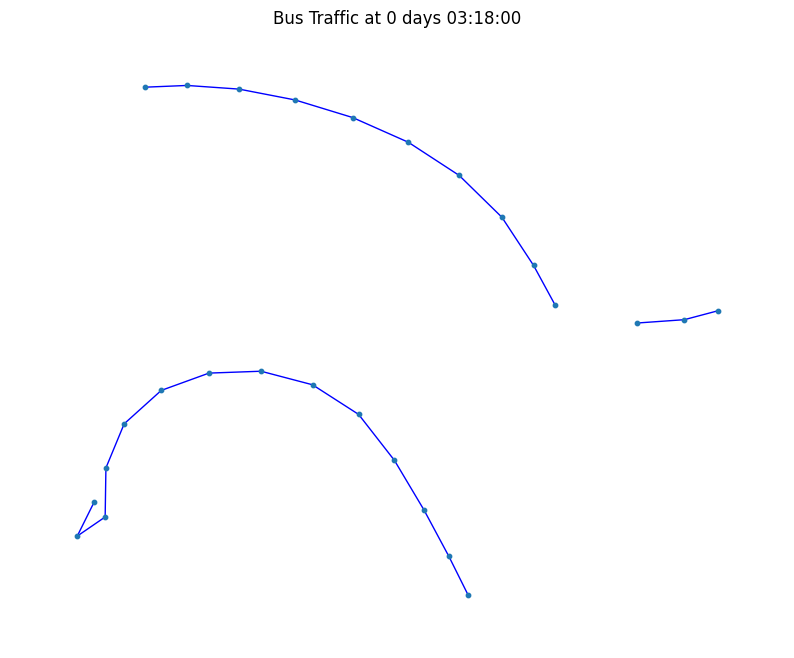

In [44]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime, timedelta

def parse_time(time_str: str) -> timedelta:
    """Convert HH:MM:SS time format to timedelta."""
    h, m, s = map(int, time_str.split(":"))
    return timedelta(hours=h, minutes=m, seconds=s)


def build_bus_temporal_graphs(
    stop_times_df: pd.DataFrame,
    trips_df: pd.DataFrame,
    routes_df: pd.DataFrame,
    interval: int = 15
) -> Dict[int, nx.Graph]:
    """Create temporal graphs for buses only (route_type = 3)."""
    print("Filtering data for buses and building temporal graphs...")
    
    # Filter for buses
    bus_routes = routes_df[routes_df['route_type'] == 3]['route_id']
    bus_trips = trips_df[trips_df['route_id'].isin(bus_routes)]['trip_id']
    bus_stop_times = stop_times_df[stop_times_df['trip_id'].isin(bus_trips)].copy()

    # Add the next stop to create edges
    bus_stop_times = bus_stop_times.sort_values(['trip_id', 'stop_sequence'])
    bus_stop_times['next_stop_id'] = bus_stop_times.groupby('trip_id')['stop_id'].shift(-1)
    
    # Parse time columns
    bus_stop_times['arrival_time'] = bus_stop_times['arrival_time'].map(parse_time)
    bus_stop_times['departure_time'] = bus_stop_times['departure_time'].map(parse_time)

    # Time interval aggregation
    start_time = bus_stop_times['arrival_time'].min()
    end_time = bus_stop_times['departure_time'].max()

    temporal_graphs = {}
    current_time = start_time

    while current_time < end_time:
        next_time = current_time + timedelta(minutes=interval)
        active_edges = bus_stop_times[
            (bus_stop_times['arrival_time'] >= current_time) &
            (bus_stop_times['departure_time'] < next_time)
        ][['stop_id', 'next_stop_id']].dropna()

        G = nx.Graph()
        G.add_edges_from(active_edges.itertuples(index=False, name=None))
        temporal_graphs[current_time] = G
        current_time = next_time

    print(f"Built {len(temporal_graphs)} temporal graphs for buses.")
    return temporal_graphs

def animate_bus_traffic(temporal_graphs: Dict[int, nx.Graph], interval: int = 500, save_path: str = None):
    """Animate traffic flow for buses using temporal graphs, with an option to save."""
    fig, ax = plt.subplots(figsize=(10, 8))

    pos = None  # Store positions for consistency across frames

    def update(frame):
        ax.clear()
        time, graph = frame
        nonlocal pos
        
        ax.set_title(f"Bus Traffic at {time}")
        if pos is None:
            pos = nx.spring_layout(graph)
        
        nx.draw(graph, pos, ax=ax, node_size=10, edge_color='blue')
    
    frames = [(time, G) for time, G in temporal_graphs.items()]
    ani = animation.FuncAnimation(
        fig, update, frames=frames, interval=interval, repeat=False
    )
    
    if save_path:
        print(f"Saving animation to {save_path}...")
        ani.save(save_path, fps=1000 // interval, writer='ffmpeg' if save_path.endswith('.mp4') else 'imagemagick')
        print(f"Animation saved to {save_path}.")
    
    plt.show()

# Save animation to a file
output_file = "bus_traffic_animation.mp4"  # Change to .gif for a GIF file

# Filter and build bus-specific temporal graphs
bus_temporal_graphs = build_bus_temporal_graphs(
    data.get_data("stop_times"), data.get_data("trips"), data.get_data("routes")
)

animate_bus_traffic(bus_temporal_graphs, interval=500, save_path=output_file)


In [ ]:
from PIL import Image
import os

def save_temporal_map_frames(
    stop_times_df: pd.DataFrame,
    stops_df: pd.DataFrame,
    trips_df: pd.DataFrame,
    routes_df: pd.DataFrame,
    graphs: Dict[int, nx.Graph],
    timestamps: List[str],
    output_dir: str
):
    """Generate map frames for animation."""
    os.makedirs(output_dir, exist_ok=True)

    for timestamp in tqdm(timestamps, desc="Rendering Frames"):
        vehicles_by_type = get_active_vehicles_enhanced(
            stop_times_df, stops_df, trips_df, routes_df, timestamp
        )
        m = visualize_temporal_network_with_routes(
            vehicles_by_type, graphs, stops_df, timestamp
        )
        map_file = os.path.join(output_dir, f"frame_{timestamp.replace(':', '-')}.png")
        m.save(map_file)
    print(f"Frames saved to {output_dir}")


def animate_map_frames(output_dir: str, output_file: str, frame_duration: int = 500):
    """Combine map frames into a video."""
    frames = sorted(
        [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')]
    )

    images = [Image.open(f) for f in frames]
    images[0].save(
        output_file,
        save_all=True,
        append_images=images[1:],
        duration=frame_duration,
        loop=0,
        format="GIF"
    )
    print(f"Animation saved to {output_file}")


# Usage Example:
output_dir = "map_frames"
output_file = "warsaw_traffic_animation.gif"
timestamps = [f"{hour:02d}:{minute:02d}:00" for hour in range(6, 24) for minute in range(0, 60, 15)]

# Generate frames for each timestamp
save_temporal_map_frames(
    data.get_data("stop_times"),
    data.get_data("stops"),
    data.get_data("trips"),
    data.get_data("routes"),
    graphs,
    timestamps,
    output_dir
)

# Combine frames into an animation
animate_map_frames(output_dir, output_file)


Rendering Frames:  38%|███▊      | 27/72 [12:55:22<24:45:05, 1980.13s/it]

In [42]:
# Verify data
datasets = ["stop_times", "trips", "routes"]
for dataset in datasets:
    df = data.get_data(dataset)
    if df is None:
        print(f"Dataset {dataset} is not loaded. Please check your data directory and load_all_data function.")
    else:
        print(f"Dataset {dataset}: {len(df)} rows loaded.")

# Reload data if necessary
if any(data.get_data(ds) is None for ds in datasets):
    print("Reloading data...")
    data.load_all_data(max_workers=4)


2024-12-10 15:32:51,626 - INFO - Starting data load with 4 workers


Dataset stop_times is not loaded. Please check your data directory and load_all_data function.
Dataset trips is not loaded. Please check your data directory and load_all_data function.
Dataset routes is not loaded. Please check your data directory and load_all_data function.
Reloading data...


Overall progress:   0%|          | 0/7 [00:00<?, ?it/s]2024-12-10 15:32:53,316 - INFO - Started loading agency
2024-12-10 15:32:53,389 - INFO - Started loading calendar
2024-12-10 15:32:53,607 - INFO - Started loading routes
2024-12-10 15:32:53,642 - INFO - Started loading shapes
2024-12-10 15:32:54,581 - INFO - Finished loading calendar: 10 rows
2024-12-10 15:32:54,586 - INFO - Finished loading agency: 2 rows
Overall progress:  29%|██▊       | 2/7 [00:02<00:12,  2.51s/it, Completed: agency]  2024-12-10 15:32:54,593 - INFO - Started loading stop_times
2024-12-10 15:32:54,644 - INFO - Finished loading routes: 3334 rows
2024-12-10 15:32:54,645 - INFO - Started loading trips
Overall progress: 100%|██████████| 7/7 [00:21<00:00,  3.13s/it, Completed: stop_times]


In [25]:
!pip install imageio

   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/315.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/315.4 kB ? eta -:--:--
   --- ----------------------------------- 30.7/315.4 kB 262.6 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/315.4 kB 245.8 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/315.4 kB 328.2 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/315.4 kB 554.9 kB/s eta 0:00:01
   -------------------- ----------------- 174.1/315.4 kB 700.2 kB/s eta 0:00:01
   ------------------------------ ------- 256.0/315.4 kB 874.6 kB/s eta 0:00:01
   -------------------------------------- 315.4/315.4 kB 978.2 kB/s eta 0:00:00


# P8.8

What is the fastest path from my home to University ?

In [55]:
def parse_time_to_minutes(time_str):
    """Convert HH:MM:SS to minutes since midnight, handling hours > 23."""
    hours, minutes, _ = map(int, time_str.split(':'))
    return hours * 60 + minutes

In [56]:
stops_df = data.get_data("stops")
stop_times_df = data.get_data("stop_times")
trips_df = data.get_data("trips")
routes_df = data.get_data("routes")

goclawek_id = stops_df[stops_df['stop_name'] == "Gocławek"]['stop_id'].values[0]
koszykowa_id = stops_df[stops_df['stop_name'] == "Koszykowa"]['stop_id'].values[0]

import networkx as nx

# Initialize the graph
bus_graph = nx.DiGraph()

# Add edges with weights (travel times)
for _, trip in stop_times_df.groupby('trip_id'):
    for i in range(len(trip) - 1):
        start = trip.iloc[i]
        end = trip.iloc[i + 1]
        travel_time = parse_time_to_minutes(end['arrival_time']) - parse_time_to_minutes(start['departure_time'])
        
        bus_graph.add_edge(start['stop_id'], end['stop_id'], weight=travel_time)

# Use Dijkstra's algorithm
fastest_path = nx.shortest_path(bus_graph, source=goclawek_id, target=koszykowa_id, weight='weight')
fastest_time = nx.shortest_path_length(bus_graph, source=goclawek_id, target=koszykowa_id, weight='weight')

# Get stop names for the path
path_stop_names = stops_df[stops_df['stop_id'].isin(fastest_path)]['stop_name'].tolist()

print("Fastest Path:", path_stop_names)
print("Total Travel Time (minutes):", fastest_time)



Fastest Path: ['Koszykowa', 'Książęca', 'Noakowskiego', 'Solec', 'Mokotowska', 'Wiatraczna', 'Pl. Szembeka', 'Grenadierów', 'Gocławek', 'Żółkiewskiego', 'Rondo Waszyngtona', 'Pl. Konstytucji', 'Pl. Trzech Krzyży']
Total Travel Time (minutes): 24


Fastest Path: ['Koszykowa', 'Książęca', 'Noakowskiego', 'Solec', 'Mokotowska', 'Wiatraczna', 'Pl. Szembeka', 'Grenadierów', 'Gocławek', 'Żółkiewskiego', 'Rondo Waszyngtona', 'Pl. Konstytucji', 'Pl. Trzech Krzyży']
Total Travel Time (minutes): 24